| **iMARGI_interaction_and_enhancer_overlap_analysis.ipynb** | Calculate and visualize iMARGI RNA–DNA interaction statistics:  
1. Compute the percentage of intra- vs. inter-chromosomal contacts from `.pairs.gz` files and plot a stacked bar chart.  
2. Extract mitochondrial RNA–DNA interaction sites, merge ±250 bp DNA-end regions, quantify overlap with a candidate super-enhancer BED, and plot the percentage of enhancers overlapped per sample. |


In [3]:
# Cell 1: Imports & Plotting Configuration
import pandas as pd           # for DataFrame operations
import gzip                   # to read compressed .pairs.gz files
from collections import Counter  # (imported but not used in this script)
import matplotlib.pyplot as plt  # for plotting
plt.rcParams['font.size'] = 12   # set global font size for plots


Control: intra 51.21%, inter 48.79%
HG+TNFα (Day 3): intra 34.67%, inter 65.33%
HG+TNFα (Day 7): intra 26.72%, inter 73.28%


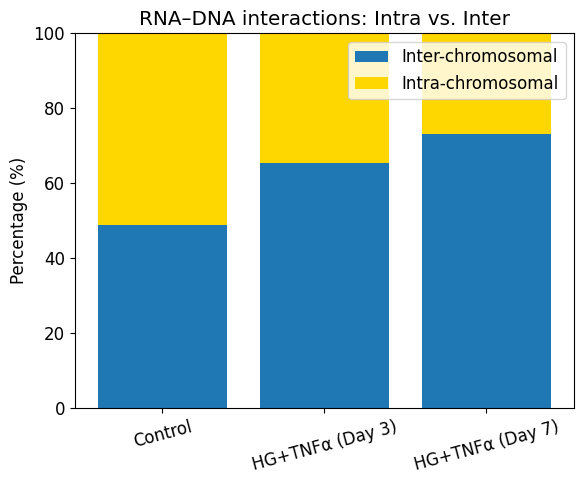

In [4]:
# ------------------------------------------------------------------------------
# Part 1: Intra- vs. Inter-chromosomal Interaction Percentages
# ------------------------------------------------------------------------------

# Sample iMARGI .pairs.gz file paths keyed by sample label
pairs_files = {
    "Control": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900120.pairs.gz",
    "HG+TNFα (Day 3)": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900121.pairs.gz",
    "HG+TNFα (Day 7)": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900122.pairs.gz"
}

# Lists to store computed percentages and labels
intra_ratios = []
inter_ratios = []
labels       = []

# Loop over each sample file
for sample_name, file_path in pairs_files.items():
    intra_count = 0
    inter_count = 0
    total       = 0

    # Open the compressed .pairs.gz file in text mode
    with gzip.open(file_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue  # skip header lines
            cols = line.strip().split("\t")
            chrom1, chrom2 = cols[1], cols[3]  # RNA-end and DNA-end chromosomes
            total += 1
            if chrom1 == chrom2:
                intra_count += 1
            else:
                inter_count += 1

    # Compute percentages
    intra_ratio = intra_count / total * 100
    inter_ratio = inter_count / total * 100

    # Store for plotting
    labels.append(sample_name)
    intra_ratios.append(intra_ratio)
    inter_ratios.append(inter_ratio)

    # Print summary for each sample
    print(f"{sample_name}: intra {intra_ratio:.2f}%, inter {inter_ratio:.2f}%")

# Plot a stacked bar chart of inter vs. intra
x = range(len(labels))
plt.figure(figsize=(6, 5))

# Bottom layer: inter-chromosomal interactions
plt.bar(x, inter_ratios, color="#1f77b4", label="Inter-chromosomal")

# Top layer: intra-chromosomal interactions
plt.bar(x, intra_ratios, bottom=inter_ratios, color="#FFD700", label="Intra-chromosomal")

plt.xticks(x, labels, rotation=15)
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.legend()
plt.title("RNA–DNA interactions: Intra vs. Inter")
plt.tight_layout()
plt.show()

In [1]:
# ------------------------------------------------------------------------------
# Part 2: mtRNA-binding Sites vs. Super-Enhancers Overlap
# ------------------------------------------------------------------------------

import pybedtools  # for interval arithmetic

# Load the BED of candidate super-enhancer regions (hg19 in this example)
candidate_bed = pybedtools.BedTool(
    "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/ref/HUVEC_superenhancer_hg19.bed"
)

# Same sample files as above, keyed by a simpler label
pairs_files = {
    "Day0": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900120.pairs.gz",
    "Day3": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900121.pairs.gz",
    "Day7": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900122.pairs.gz"
}

total_regions = candidate_bed.count()
print(f"Total number of super-enhancer regions: {total_regions}")

results = {}

# Loop over each .pairs.gz to extract mtRNA-binding DNA sites
for name, pf in pairs_files.items():
    print(f"\n===> Processing {name}")
    dna_sites = []

    with gzip.open(pf, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            cols = line.strip().split("\t")
            rna_chr = cols[1]
            dna_chr = cols[3]
            dna_pos = int(cols[4])
            # Keep only pairs where RNA-end is mitochondrial (chrM variants)
            if rna_chr in ["chrM", "chrMT", "MT"]:
                # Create a 1-bp interval at the DNA-end position
                dna_sites.append([dna_chr, dna_pos, dna_pos + 1])

    if not dna_sites:
        print(f"{name}: No mtRNA-binding reads found")
        results[name] = (0, 0)
        continue

    # Merge DNA-end sites ±250 bp into contiguous intervals
    dna_bed = pybedtools.BedTool(dna_sites).sort().merge(d=500)

    # Count how many super-enhancers overlap any merged DNA site
    overlap_count = candidate_bed.intersect(dna_bed, u=True).count()
    percentage    = overlap_count / total_regions * 100
    results[name] = (overlap_count, percentage)

    print(f"{name}: {overlap_count} enhancers overlapped ({percentage:.2f}%)")

# Plot bar chart of enhancer overlap percentages
labels         = list(results.keys())
percentages    = [results[k][1] for k in labels]

plt.figure(figsize=(6, 4))
plt.bar(labels, percentages, color=["#6baed6", "#fd8d3c", "#74c476"])
plt.ylabel("Percentage of super-enhancers overlapped (%)")
plt.title("Overlap of mtRNA-binding sites with super-enhancers")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

Total number of super-enhancer regions: 912

===> Processing Day0
Day0: Number of enhancer regions overlapping with iMARGI = 820
Percentage = 89.91%

===> Processing Day3


The proportion is very high (89–92%)

Almost all super-enhancers overlap with the mtRNA-binding regions detected by iMARGI

This indicates that mtRNA binding on enhancers is very widespread and does not occur only in a few regions

The proportions are almost the same across the three time points

The difference between Day 3 and Day 7 is very small (91.67% vs 89.36%)